In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST data
import mnist

In [8]:
#from vae.utils.functionals import load_mnist
#train_data, train_labels, train_size = load_mnist(data_path = './vae/data/train-images-idx3-ubyte',
#                                                  label_path = './vae/data/train-labels-idx1-ubyte')

In [4]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

### Model

In [91]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})
    
        

### Training

In [92]:
def train_mnist(network_architecture, 
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    images = mnist.train_images() 
    train_size = len(images)
    train_data = images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [93]:
network_architecture = dict(n_hidden_enc_1 = 500, 
                             n_hidden_enc_2 = 500, 
                             n_hidden_dec_1 = 500, 
                             n_hidden_dec_2 = 500, 
                             n_input = 784, 
                             n_z = 20)  

vae = train_mnist(network_architecture, n_epoch = 5)

Epoch: 1/5 Loss = 244.7730
Epoch: 2/5 Loss = 185.5693
Epoch: 3/5 Loss = 159.4395
Epoch: 4/5 Loss = 140.9813
Epoch: 5/5 Loss = 130.2693


### Visualize predictions

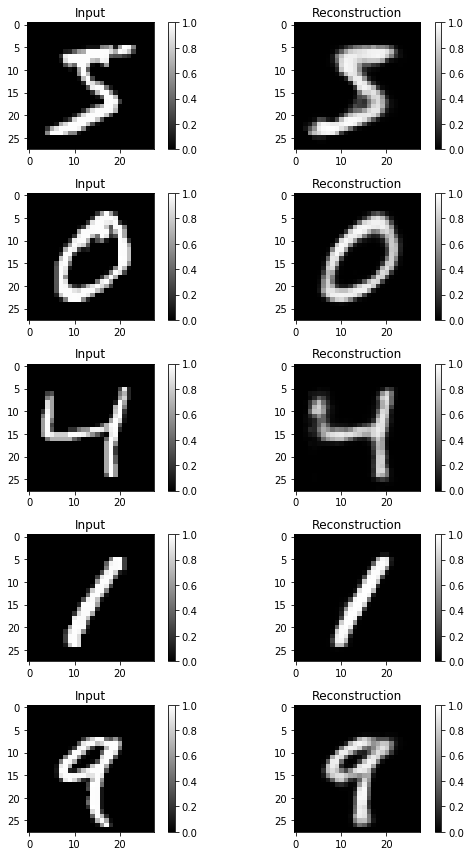

In [9]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:100,]
recon_x = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

### Visualize latent space

In [11]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=2) 

vae_2d = train_mnist(network_architecture, n_epoch = 10)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 Loss = 186.51265
Epoch: 0002 Loss = 162.91172
Epoch: 0003 Loss = 157.65984
Epoch: 0004 Loss = 154.84908
Epoch: 0005 Loss = 152.96418
Epoch: 0006 Loss = 151.35505
Epoch: 0007 Loss = 150.02256
Epoch: 0008 Loss = 148.98185
Epoch: 0009 Loss = 148.02150
Epoch: 0010 Loss = 147.38574


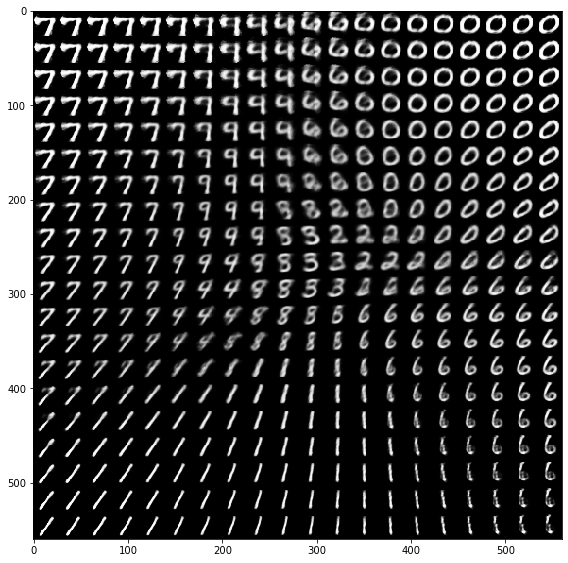

In [12]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

### Evaluation
Consider metrics for generative models: reconstruction error, marginal log-likelihood (negative ELBO).

In [31]:
def BCE(x, y):
    """
    Calculate binary cross entropy loss for reconstruction loss in the ELBO.
    """

    loss = np.sum(-y * np.log(x + 10e-8) - (1 - y) * np.log(1 - x + 10e-8))

    return loss

In [94]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:1000,]
recon_x = vae.reconstruct(x_sample)

In [95]:
def evaluate(X, recon_X):
        """
        Evaluate the accuracy of the model with reconstruction error and marginal log-likelihood.
        """
        rec_loss = BCE(recon_X, X) / len(X)
        # Marginal log-likelihood of data = - ELBO
        marg_likelihood = - vae.train(X)
        
        return rec_loss, marg_likelihood

In [96]:
evaluate(x_sample, recon_x)

(106.49117566196126, -124.59328)

### Comparative analysis
Compared to 2 generative models for images:
    - GAN: https://pypi.org/project/pygan/
    - Wake-sleep: https://github.com/jackklys/wake-sleep-modifications/tree/master/datasets